In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm.notebook import tqdm
import os
import numpy as np
import zipfile
reprocess_data = True
from PIL import Image
from torchsummary import summary
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
path_to_train = "../input/dogs-vs-cats/train.zip"
if not os.path.isdir("train"):
    with zipfile.ZipFile(path_to_train, 'r') as zip_ref:
        zip_ref.extractall()
    print('Архив "train.zip" успешно распакован в текущую директорию.')
else:
    print('Датасет train.zip уже распакован')

Архив "train.zip" успешно распакован в текущую директорию.


In [5]:
train_path = "./train"
train_files = os.listdir(train_path)
print(len(train_files))

25000


In [6]:
# Класс-обертка для набора данных
class Dataset():
    def __init__(self,filelist,filepath,transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform
    def __len__(self):
        return int(len(self.filelist))
    def __getitem__(self,index):
        imgpath = os.path.join(self.filepath,self.filelist[index])
        img = Image.open(imgpath)
        if "dog" in imgpath:
            label = float(1)
        else:
            label = float(0)
        if self.transform is not None:
            img = self.transform(img)
        return (img,label)
            
        

In [7]:
# transformations изменяет размер изображений на 120х120
transformations = transforms.Compose([transforms.Resize((120,120)),transforms.ToTensor()])
train = Dataset(train_files,train_path,transformations)
# Разделим набор данных на обучающую и валидационный, чтобы избежать переобучения
train_set,val_set = torch.utils.data.random_split(train,[22500,2500]) 

In [8]:
# Проверим сбалансированность классов в обучающей выборке
train_arr_labels = np.array([train_set.__getitem__(x)[1] for x in range(len(train_set))])
dogs_count = (train_arr_labels==1).sum()
cats_count = (train_arr_labels==0).sum()
print(f"Собак в выборке: {dogs_count}")
print(f"Котов в выборке: {cats_count}")

Собак в выборке: 11251
Котов в выборке: 11249


### Количество котов и собак практически совпадает, поэтому выборку можно считать сбалансированной

In [9]:
train_dataset = torch.utils.data.DataLoader(dataset = train_set,batch_size = batch_size,shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val_set,batch_size = batch_size,shuffle=True)

In [19]:
# Модель классификации представляет собой сверточную нейронную сеть, с четырьмя сверточными слоями
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,9),
            nn.Dropout(0.2), # Добавляем Dropout, чтобы избежать переобучения
            nn.LeakyReLU(0.1),
            # Испоьзуем AvgPool, чтобы уменьшить размер изображения и 
            # уменьшить требуемое количество вычислительных ресурсов
            nn.AvgPool2d(2,2)
            )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,7),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d(2,2)
            )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128,256,5),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d(2,2)
            )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256,512,3),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d(2,2)
            )
        
            
        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512*4*4,256),
        nn.Dropout(0.2),
        nn.LeakyReLU(0.1),
        nn.Linear(256,128),
        nn.Dropout(0.2),
        nn.LeakyReLU(0.1),
        nn.Linear(128,1),
        )
        
        self.act = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x)
        x = self.act(x)
        return x
    

# Класс для обучения модели
class Classificator():
    def __init__(self):
        self.model = Model().to(device)
        self.optimiser = optim.Adam(self.model.parameters(),lr=0.0003,
                                    weight_decay=1e-4) # Добавим регуляризацию, чтобы избежать переобучения
        self.loss = nn.BCELoss().to(device)
        self.accuracy_history = []
        self.precision_history = []
        self.recall_history = []
        self.f1_score_history = []
        self.roc_auc_history = []
        self.current_epoch = 0
        
    def save_control_point(self):
        torch.save({'epoch': self.current_epoch,
              'model_state_dict': self.model.state_dict(),
              'optimiser_state_dict': self.optimiser.state_dict()},
              'Model.pth')
        print("Model saved.")
    
    def load_control_point(self):
        checkpoint = torch.load("Model.pth")
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.model.optimiser(checkpoint["optimiser_state_dict"])
        self.current_epoch = checkpoint['epoch']
        
    # Add metrics to end of files
    def self_metrics_to_file(self):
        with open('accuracy.txt', 'a+') as f:
            for metric in self.accuracy_history:
                f.write(str(metric) + "\n")
            f.close()
        with open('precision.txt', 'a+') as f:
            for metric in self.precision_history:
                f.write(str(metric) + "\n")
            f.close()
        with open('f1_score.txt', 'a+') as f:
            for metric in self.f1_score_history:
                f.write(str(metric) + "\n")
            f.close()
        with open('roc_auc.txt', 'a+') as f:
            for metric in self.roc_auc_history:
                f.write(str(metric) + "\n")
            f.close()
    
    # Функция, определяющая определяющая одну эпоху обучения
    def train_step(self, train_dataset, epochs):
        self.model.train()
        with tqdm(train_dataset, unit="batch") as tepoch:
            tepoch.set_description(f'Epoch {self.current_epoch+1}/{epochs}')
            for data,label in tepoch:
                data,label = data.to(device), label.float().to(device)
                self.optimiser.zero_grad()
                output = self.model(data).view(label.shape[0])
                loss = self.loss(output,label)
                loss.backward()
                self.optimiser.step()
                tepoch.set_description(f"Epoch[{self.current_epoch+1}/{epochs}] Loss: {loss.mean().item()}")
    
    # Функция, используемая при валидации модели, считает метрики, сохраняет их соответсвующие списки и выводит значения метрик
    def val_step(self, val_dataset):
        print("Calculating metrics...")
        self.model.eval()
        val_predicitions = []
        val_labels = []
        with torch.no_grad():
            for val_data,val_label in val_dataset:
                val_data,val_label = val_data.to(device),val_label.float().to(device)
                val_output = self.model(val_data).view(val_label.shape[0])
                loss_val = self.loss(val_output,val_label)

                val_predicitions.append(val_output.cpu().detach().numpy())
                val_labels.append(val_label.cpu().detach().numpy())

            val_predicitions = np.concatenate(val_predicitions)
            binary_val_predictions = [1 if p >= 0.5 else 0 for p in val_predicitions]
            val_labels = np.concatenate(val_labels)

            val_accuracy = accuracy_score(val_labels, binary_val_predictions)
            val_presion = precision_score(val_labels, binary_val_predictions)
            val_recall = recall_score(val_labels, binary_val_predictions)
            val_f = 2 * val_presion * val_recall / (val_presion + val_recall)
            val_roc_auc = roc_auc_score(val_labels, val_predicitions)

            self.accuracy_history.append(val_accuracy)
            self.precision_history.append(val_presion)
            self.recall_history.append(val_recall)
            self.f1_score_history.append(val_f)
            self.roc_auc_history.append(val_roc_auc)

            print(f"Epoch #{self.current_epoch+1} validation accuracy {val_accuracy}")
            print(f"Epoch #{self.current_epoch+1} validation precision {val_presion}")
            print(f"Epoch #{self.current_epoch+1} validation recall {val_recall}")
            print(f"Epoch #{self.current_epoch+1} validation f1-score {val_f}")
            print(f"Epoch #{self.current_epoch+1} validation roc-auc {val_roc_auc}")

    def train(self, train_dataset, val_dataset, epochs, val_freequency=1):
        for epoch in range(self.current_epoch, epochs):
            self.train_step(train_dataset, epochs)
            if epoch % val_freequency == 0:
                self.val_step(val_dataset)
            self.current_epoch += 1
        self.save_control_point()
        self.self_metrics_to_file()

In [20]:
classificator = Classificator()
summary(classificator.model, (3,120,120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          15,616
           Dropout-2         [-1, 64, 112, 112]               0
         LeakyReLU-3         [-1, 64, 112, 112]               0
         AvgPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 50, 50]         401,536
           Dropout-6          [-1, 128, 50, 50]               0
         LeakyReLU-7          [-1, 128, 50, 50]               0
         AvgPool2d-8          [-1, 128, 25, 25]               0
            Conv2d-9          [-1, 256, 21, 21]         819,456
          Dropout-10          [-1, 256, 21, 21]               0
        LeakyReLU-11          [-1, 256, 21, 21]               0
        AvgPool2d-12          [-1, 256, 10, 10]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
          Dropout-14            [-1, 51

In [21]:
classificator.train(train_dataset, val_dataset, 100)

  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #1 validation accuracy 0.516
Epoch #1 validation precision 0.5079689415610952
Epoch #1 validation recall 0.9951961569255404
Epoch #1 validation f1-score 0.6726190476190477
Epoch #1 validation roc-auc 0.6388631288724025


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #2 validation accuracy 0.6076
Epoch #2 validation precision 0.5781796966161027
Epoch #2 validation recall 0.7934347477982386
Epoch #2 validation f1-score 0.6689166385420182
Epoch #2 validation roc-auc 0.677654193698684


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #3 validation accuracy 0.6636
Epoch #3 validation precision 0.7
Epoch #3 validation recall 0.5716573258606885
Epoch #3 validation f1-score 0.629352137505509
Epoch #3 validation roc-auc 0.7133732565588842


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #4 validation accuracy 0.6608
Epoch #4 validation precision 0.6321687541199736
Epoch #4 validation recall 0.7678142514011209
Epoch #4 validation f1-score 0.6934201012292119
Epoch #4 validation roc-auc 0.7493355195747325


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #5 validation accuracy 0.7004
Epoch #5 validation precision 0.657035175879397
Epoch #5 validation recall 0.8374699759807847
Epoch #5 validation f1-score 0.7363604364660331
Epoch #5 validation roc-auc 0.7837125015760011


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #6 validation accuracy 0.7344
Epoch #6 validation precision 0.7951564076690212
Epoch #6 validation recall 0.6309047237790232
Epoch #6 validation f1-score 0.7035714285714286
Epoch #6 validation roc-auc 0.8145797213310217


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #7 validation accuracy 0.7272
Epoch #7 validation precision 0.6832579185520362
Epoch #7 validation recall 0.8462770216172938
Epoch #7 validation f1-score 0.7560801144492132
Epoch #7 validation roc-auc 0.8252171681389877


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #8 validation accuracy 0.7492
Epoch #8 validation precision 0.74296875
Epoch #8 validation recall 0.7614091273018415
Epoch #8 validation f1-score 0.7520759193357058
Epoch #8 validation roc-auc 0.8347864542633308


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #9 validation accuracy 0.766
Epoch #9 validation precision 0.7699186991869919
Epoch #9 validation recall 0.7582065652522018
Epoch #9 validation f1-score 0.764017749092376
Epoch #9 validation roc-auc 0.8454479010866568


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #10 validation accuracy 0.748
Epoch #10 validation precision 0.7785778577857786
Epoch #10 validation recall 0.6925540432345877
Epoch #10 validation f1-score 0.733050847457627
Epoch #10 validation roc-auc 0.8333541333466453


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #11 validation accuracy 0.78
Epoch #11 validation precision 0.7881286067600989
Epoch #11 validation recall 0.7654123298638911
Epoch #11 validation f1-score 0.776604386677498
Epoch #11 validation roc-auc 0.8598661503143361


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #12 validation accuracy 0.7836
Epoch #12 validation precision 0.8218181818181818
Epoch #12 validation recall 0.7237790232185749
Epoch #12 validation f1-score 0.7696892294593444
Epoch #12 validation roc-auc 0.8660619942796763


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #13 validation accuracy 0.7848
Epoch #13 validation precision 0.7505285412262156
Epoch #13 validation recall 0.8526821457165733
Epoch #13 validation f1-score 0.7983508245877061
Epoch #13 validation roc-auc 0.8749183199477246


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #14 validation accuracy 0.8012
Epoch #14 validation precision 0.7861491628614916
Epoch #14 validation recall 0.8270616493194556
Epoch #14 validation f1-score 0.8060866172454155
Epoch #14 validation roc-auc 0.8878303282114102


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #15 validation accuracy 0.8052
Epoch #15 validation precision 0.835387323943662
Epoch #15 validation recall 0.7598078462770216
Epoch #15 validation f1-score 0.7958071278825996
Epoch #15 validation roc-auc 0.8929855315107403


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #16 validation accuracy 0.808
Epoch #16 validation precision 0.7788252356780275
Epoch #16 validation recall 0.8598879103282626
Epoch #16 validation f1-score 0.8173515981735159
Epoch #16 validation roc-auc 0.8949932127956561


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #17 validation accuracy 0.8224
Epoch #17 validation precision 0.8334714167357083
Epoch #17 validation recall 0.8054443554843875
Epoch #17 validation f1-score 0.8192182410423453
Epoch #17 validation roc-auc 0.9022776974577265


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #18 validation accuracy 0.7992
Epoch #18 validation precision 0.8927444794952681
Epoch #18 validation recall 0.6797437950360288
Epoch #18 validation f1-score 0.7718181818181817
Epoch #18 validation roc-auc 0.9045797789310585


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #19 validation accuracy 0.8296
Epoch #19 validation precision 0.8581375108790252
Epoch #19 validation recall 0.789431545236189
Epoch #19 validation f1-score 0.8223519599666389
Epoch #19 validation roc-auc 0.9124389839609497


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #20 validation accuracy 0.818
Epoch #20 validation precision 0.8839458413926499
Epoch #20 validation recall 0.7317854283426741
Epoch #20 validation f1-score 0.8007008322382829
Epoch #20 validation roc-auc 0.9103148226014866


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #21 validation accuracy 0.828
Epoch #21 validation precision 0.8595258999122037
Epoch #21 validation recall 0.7838270616493195
Epoch #21 validation f1-score 0.8199329983249581
Epoch #21 validation roc-auc 0.9139193049083552


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #22 validation accuracy 0.8396
Epoch #22 validation precision 0.8154761904761905
Epoch #22 validation recall 0.877502001601281
Epoch #22 validation f1-score 0.8453528731199385
Epoch #22 validation roc-auc 0.9193324283727541


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #23 validation accuracy 0.842
Epoch #23 validation precision 0.8668384879725086
Epoch #23 validation recall 0.8078462770216173
Epoch #23 validation f1-score 0.83630335681724
Epoch #23 validation roc-auc 0.9214681097395903


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #24 validation accuracy 0.8372
Epoch #24 validation precision 0.8629310344827587
Epoch #24 validation recall 0.8014411529223379
Epoch #24 validation f1-score 0.8310502283105023
Epoch #24 validation roc-auc 0.9208914693705404


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #25 validation accuracy 0.8408
Epoch #25 validation precision 0.8163568773234201
Epoch #25 validation recall 0.8791032826261009
Epoch #25 validation f1-score 0.8465690053970703
Epoch #25 validation roc-auc 0.9265938730200789


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #26 validation accuracy 0.8412
Epoch #26 validation precision 0.8029871977240398
Epoch #26 validation recall 0.9039231385108086
Epoch #26 validation f1-score 0.8504708097928437
Epoch #26 validation roc-auc 0.927955793891708


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #27 validation accuracy 0.8516
Epoch #27 validation precision 0.8305722891566265
Epoch #27 validation recall 0.8831064851881505
Epoch #27 validation f1-score 0.8560341482343811
Epoch #27 validation roc-auc 0.9328274770095852


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #28 validation accuracy 0.8632
Epoch #28 validation precision 0.8551292090837901
Epoch #28 validation recall 0.8742994395516414
Epoch #28 validation f1-score 0.8646080760095012
Epoch #28 validation roc-auc 0.9353951586529016


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #29 validation accuracy 0.8576
Epoch #29 validation precision 0.8736401673640167
Epoch #29 validation recall 0.8358686949559647
Epoch #29 validation f1-score 0.8543371522094926
Epoch #29 validation roc-auc 0.9346501981761268


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #30 validation accuracy 0.844
Epoch #30 validation precision 0.8455349959774738
Epoch #30 validation recall 0.8414731785428343
Epoch #30 validation f1-score 0.8434991974317818
Epoch #30 validation roc-auc 0.9265157929701073


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #31 validation accuracy 0.8504
Epoch #31 validation precision 0.8083157152924595
Epoch #31 validation recall 0.9183346677341874
Epoch #31 validation f1-score 0.8598200899550226
Epoch #31 validation roc-auc 0.9384204405890819


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #32 validation accuracy 0.85
Epoch #32 validation precision 0.8139367816091954
Epoch #32 validation recall 0.9071257005604484
Epoch #32 validation f1-score 0.8580083301779629
Epoch #32 validation roc-auc 0.9344837980696307


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #33 validation accuracy 0.8516
Epoch #33 validation precision 0.8190406976744186
Epoch #33 validation recall 0.9023218574859888
Epoch #33 validation f1-score 0.8586666666666666
Epoch #33 validation roc-auc 0.9322143566171883


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #34 validation accuracy 0.8528
Epoch #34 validation precision 0.8566801619433199
Epoch #34 validation recall 0.8470776621297038
Epoch #34 validation f1-score 0.8518518518518519
Epoch #34 validation roc-auc 0.9351455584931575


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #35 validation accuracy 0.854
Epoch #35 validation precision 0.8683333333333333
Epoch #35 validation recall 0.8342674139311449
Epoch #35 validation f1-score 0.8509595753368722
Epoch #35 validation roc-auc 0.9399599615743753


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #36 validation accuracy 0.8524
Epoch #36 validation precision 0.8497615262321144
Epoch #36 validation recall 0.855884707766213
Epoch #36 validation f1-score 0.8528121260470681
Epoch #36 validation roc-auc 0.9273669935148757


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #37 validation accuracy 0.8616
Epoch #37 validation precision 0.8508158508158508
Epoch #37 validation recall 0.8767013610888711
Epoch #37 validation f1-score 0.8635646687697159
Epoch #37 validation roc-auc 0.9388204408450821


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #38 validation accuracy 0.8592
Epoch #38 validation precision 0.8400303260045489
Epoch #38 validation recall 0.8871096877502002
Epoch #38 validation f1-score 0.8629283489096573
Epoch #38 validation roc-auc 0.9376082800692992


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #39 validation accuracy 0.856
Epoch #39 validation precision 0.8770144189991518
Epoch #39 validation recall 0.8278622898318655
Epoch #39 validation f1-score 0.8517298187808896
Epoch #39 validation roc-auc 0.9346514781769462


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #40 validation accuracy 0.8552
Epoch #40 validation precision 0.8780903665814151
Epoch #40 validation recall 0.8246597277822257
Epoch #40 validation f1-score 0.8505367464905036
Epoch #40 validation roc-auc 0.9337881176243954


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #41 validation accuracy 0.8464
Epoch #41 validation precision 0.8397486252945797
Epoch #41 validation recall 0.855884707766213
Epoch #41 validation f1-score 0.8477398889770024
Epoch #41 validation roc-auc 0.9335090774458095


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #42 validation accuracy 0.862
Epoch #42 validation precision 0.84715821812596
Epoch #42 validation recall 0.8831064851881505
Epoch #42 validation f1-score 0.8647589180713445
Epoch #42 validation roc-auc 0.9345535581142773


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #43 validation accuracy 0.866
Epoch #43 validation precision 0.8667736757624398
Epoch #43 validation recall 0.8646917534027222
Epoch #43 validation f1-score 0.8657314629258517
Epoch #43 validation roc-auc 0.9383986805751556


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #44 validation accuracy 0.852
Epoch #44 validation precision 0.8357524828113063
Epoch #44 validation recall 0.8759007205764612
Epoch #44 validation f1-score 0.8553557466770914
Epoch #44 validation roc-auc 0.9368796396029694


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #45 validation accuracy 0.8608
Epoch #45 validation precision 0.8544453186467349
Epoch #45 validation recall 0.8694955964771818
Epoch #45 validation f1-score 0.861904761904762
Epoch #45 validation roc-auc 0.9381705204291331


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #46 validation accuracy 0.8536
Epoch #46 validation precision 0.8393543428132206
Epoch #46 validation recall 0.8742994395516414
Epoch #46 validation f1-score 0.8564705882352941
Epoch #46 validation roc-auc 0.9371791597946624


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #47 validation accuracy 0.8572
Epoch #47 validation precision 0.862012987012987
Epoch #47 validation recall 0.8502802241793435
Epoch #47 validation f1-score 0.8561064087061668
Epoch #47 validation roc-auc 0.9366796394749692


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #48 validation accuracy 0.8524
Epoch #48 validation precision 0.8839441535776614
Epoch #48 validation recall 0.811048839071257
Epoch #48 validation f1-score 0.8459290187891441
Epoch #48 validation roc-auc 0.9363845992861436


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #49 validation accuracy 0.8472
Epoch #49 validation precision 0.8139029688631426
Epoch #49 validation recall 0.899919935948759
Epoch #49 validation f1-score 0.8547528517110266
Epoch #49 validation roc-auc 0.9329372370798317


  0%|          | 0/22 [00:00<?, ?batch/s]

Calculating metrics...
Epoch #50 validation accuracy 0.8616
Epoch #50 validation precision 0.8552321007081038
Epoch #50 validation recall 0.8702962369895917
Epoch #50 validation f1-score 0.8626984126984126
Epoch #50 validation roc-auc 0.9362172391790331


  0%|          | 0/22 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [23]:
classificator.save_control_point()
classificator.self_metrics_to_file()

Model saved.


In [27]:
epochs = np.arange(0, classificator.current_epoch) + 1
accuracy = classificator.accuracy_history
precision = classificator.precision_history
recall = classificator.recall_history
f1_score = classificator.f1_score_history
roc_auc = classificator.roc_auc_history

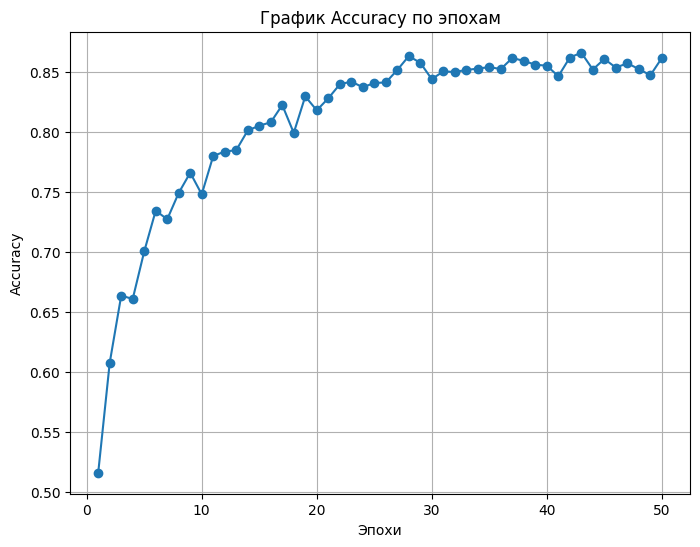

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, marker='o', linestyle='-')
plt.title('График Accuracy по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.grid(True)

plt.savefig('accuracy.png')

plt.show()

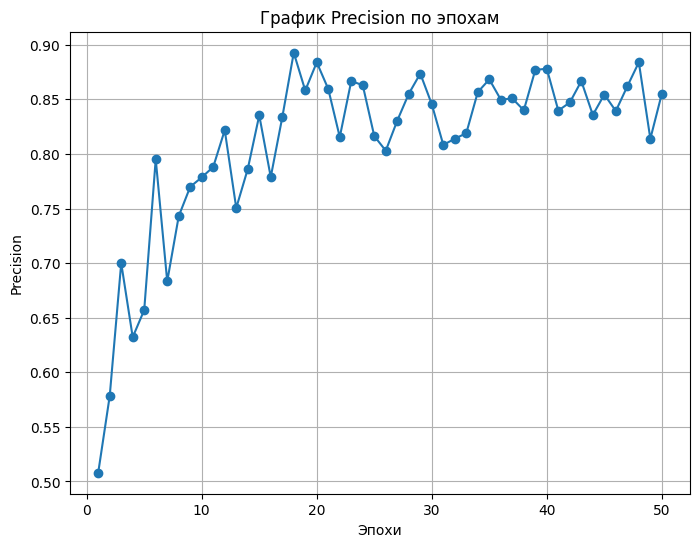

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, precision, marker='o', linestyle='-')
plt.title('График Precision по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Precision')
plt.grid(True)

plt.savefig('precision.png')

plt.show()

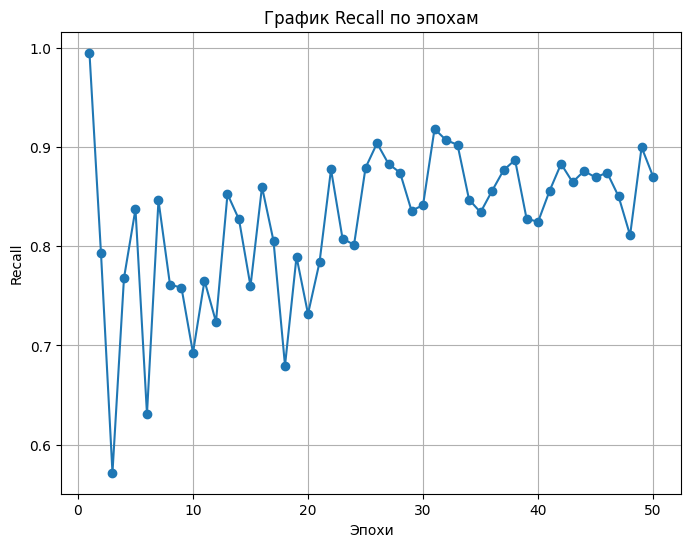

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, recall, marker='o', linestyle='-')
plt.title('График Recall по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Recall')
plt.grid(True)

plt.savefig('recall.png')

plt.show()

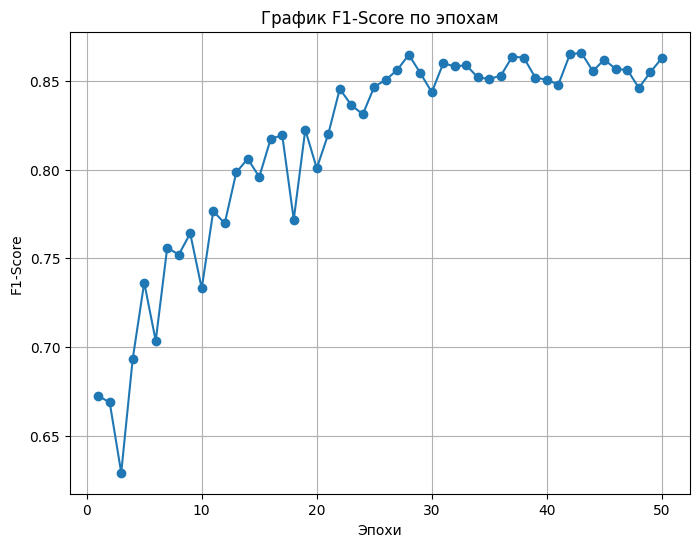

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, f1_score, marker='o', linestyle='-')
plt.title('График F1-Score по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('F1-Score')
plt.grid(True)

plt.savefig('f1-score.png')

plt.show()

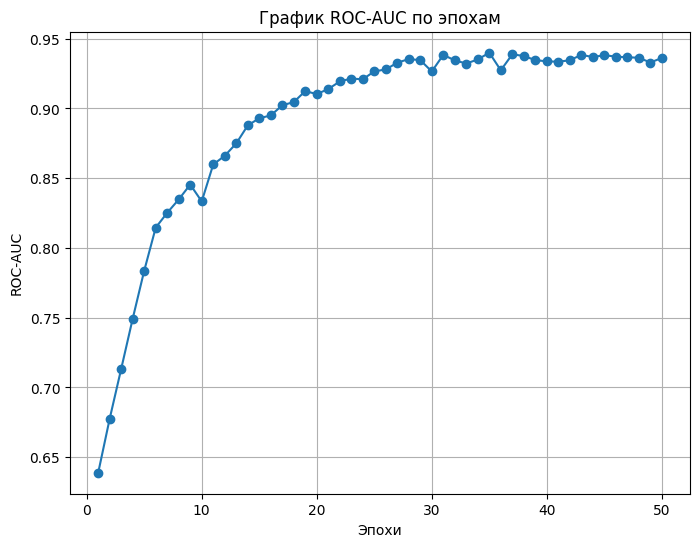

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, roc_auc, marker='o', linestyle='-')
plt.title('График ROC-AUC по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('ROC-AUC')
plt.grid(True)

plt.savefig('roc-auc.png')

plt.show()